# Saving and loading Models

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


## Saving and loading model weights

### Load and inspect CIFAR-10 dataset

The CIFAR-10 dataset consists of, in total, 60000 color images, each with one of 10 labels: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:1000]
y_test = y_test[:1000]

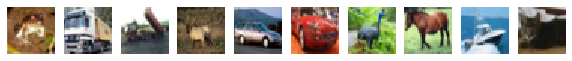

In [3]:
fig, ax = plt.subplots(1, 10, figsize=(10, 1))

for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])

### Introduce two useful functions

In [4]:
def get_test_accuracy(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: {acc:0.3f}".format(acc=test_acc))

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D

def get_new_model():
    model = Sequential([
        Conv2D(filters=16, input_shape=(32, 32, 3), kernel_size=(3, 3),
                               activation='relu', name='conv_1'),
        Conv2D(filters=8, kernel_size=(3, 3), activation='relu', name='conv_2'),
        MaxPooling2D(pool_size=(4, 4), name='pool_1'),
        Flatten(name='flatten'),
        Dense(units=32, activation='relu', name='dense_1'),
        Dense(units=10, activation='softmax', name='dense_2')
    ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

## Create simple convolutional neural network classifier

In [6]:
model = get_new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                12576     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 14,514
Trainable params: 14,514
Non-trainable params: 0
____________________________________________________

In [7]:
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.107


### Train model with ModelCheckpoint

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_path = 'model_checkpoints/checkpoint'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             frequency='epoch', save_weights_only=True, verbose=1)

In [9]:
model.fit(X_train, y_train, epochs=3, callbacks=[checkpoint])

Epoch 1/3
296/313 [===========================>..] - ETA: 0s - loss: 2.0062 - accuracy: 0.2708
Epoch 00001: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 0s 1ms/step - loss: 1.9945 - accuracy: 0.2742
Epoch 2/3
295/313 [===========================>..] - ETA: 0s - loss: 1.6563 - accuracy: 0.4005
Epoch 00002: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 0s 1ms/step - loss: 1.6507 - accuracy: 0.4022
Epoch 3/3
310/313 [============================>.] - ETA: 0s - loss: 1.5138 - accuracy: 0.4548
Epoch 00003: saving model to model_checkpoints/checkpoint
313/313 [==============================] - 0s 1ms/step - loss: 1.5135 - accuracy: 0.4542


In [10]:
%ls  model_checkpoints

assets/                         checkpoint.data-00000-of-00002  saved_model.pb
checkpoint                      checkpoint.data-00001-of-00002  variables/
checkpoint.data-00000-of-00001  checkpoint.index


In [11]:
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.467


### Create new model, load weights

In [12]:
model = get_new_model()
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.111


In [13]:
# Load weights
model.load_weights(checkpoint_path)
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.467


## Model Saving Criteria

### Create more customized checkpoint

> Note: In v2.2.x keyword error is occured like this, And it is known issue in here -> https://github.com/tensorflow/tensorflow/issues/40907:

```
Failed to format this callback filepath: "model_checkpoints_5000/checkpoint_{epoch:02d}_{batch:04d}". Reason: \'batch\'
``` 

In [14]:
# Create tensorflow checkpoint object with epoch and batch details
checkpoint_5000_path = \
    './model_checkpoints_5000/checkpoint_{epoch:02d}'
checkpoint_5000 = ModelCheckpoint(filepath=checkpoint_5000_path,
                                  save_weights_only=True,
                                 save_freq=5000,
                                  verbose=1)

In [15]:
model = get_new_model()
model.fit(X_train, 
          y_train, 
          epochs=5, 
          validation_data=(X_test, y_test), batch_size=10,
          callbacks=[checkpoint_5000])

Epoch 1/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.8397 - accuracy: 0.3161 - val_loss: 1.5790 - val_accuracy: 0.4160
Epoch 2/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.5187 - accuracy: 0.4473 - val_loss: 1.4454 - val_accuracy: 0.4700
Epoch 3/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.4150 - accuracy: 0.4911 - val_loss: 1.4227 - val_accuracy: 0.4900
Epoch 4/5
1000/1000 [==============================] - 1s 1ms/step - loss: 1.3415 - accuracy: 0.5170 - val_loss: 1.4126 - val_accuracy: 0.4790
Epoch 5/5
 967/1000 [============================>.] - ETA: 0s - loss: 1.2879 - accuracy: 0.5390
Epoch 00005: saving model to ./model_checkpoints_5000/checkpoint_05
1000/1000 [==============================] - 1s 1ms/step - loss: 1.2881 - accuracy: 0.5388 - val_loss: 1.4034 - val_accuracy: 0.4930


In [16]:
!ls -lh model_checkpoints_5000

total 360K
-rw-rw-r-- 1 chanseok chanseok   83 11월 16 16:48 checkpoint
-rw-rw-r-- 1 chanseok chanseok 174K 11월 16 16:48 checkpoint_05.data-00000-of-00001
-rw-rw-r-- 1 chanseok chanseok 3.6K 11월 16 16:22 checkpoint_05.data-00000-of-00002
-rw-rw-r-- 1 chanseok chanseok 171K 11월 16 16:22 checkpoint_05.data-00001-of-00002
-rw-rw-r-- 1 chanseok chanseok 2.0K 11월 16 16:48 checkpoint_05.index


### Working with model saving criteria

In [17]:
# Use tiny training and test set -- it will overfit
X_train_overfit = X_train[:100]
y_train_overfit = y_train[:100]
X_test_overfit = X_test[:100]
y_test_overfit = y_test[:100]

In [18]:
model = get_new_model()

In [19]:
checkpoint_best_path = 'model_checkpoints_best/checkpoint'
checkpoint_best = ModelCheckpoint(filepath=checkpoint_best_path,
                                  save_weights_only=True,
                                  save_freq='epoch',
                                  monitor='val_accuracy',
                                  save_best_only=True,
                                  verbose=1)

In [20]:
history = model.fit(X_train_overfit,
                    y_train_overfit, 
                    epochs=50,
                    validation_data=(X_test_overfit, y_test_overfit),
                    batch_size=10,
                    callbacks=[checkpoint_best],
                    verbose=0)


Epoch 00001: val_accuracy improved from -inf to 0.12000, saving model to model_checkpoints_best/checkpoint

Epoch 00002: val_accuracy did not improve from 0.12000

Epoch 00003: val_accuracy did not improve from 0.12000

Epoch 00004: val_accuracy did not improve from 0.12000

Epoch 00005: val_accuracy did not improve from 0.12000

Epoch 00006: val_accuracy did not improve from 0.12000

Epoch 00007: val_accuracy did not improve from 0.12000

Epoch 00008: val_accuracy did not improve from 0.12000

Epoch 00009: val_accuracy improved from 0.12000 to 0.13000, saving model to model_checkpoints_best/checkpoint

Epoch 00010: val_accuracy did not improve from 0.13000

Epoch 00011: val_accuracy did not improve from 0.13000

Epoch 00012: val_accuracy did not improve from 0.13000

Epoch 00013: val_accuracy improved from 0.13000 to 0.14000, saving model to model_checkpoints_best/checkpoint

Epoch 00014: val_accuracy improved from 0.14000 to 0.15000, saving model to model_checkpoints_best/checkpoint

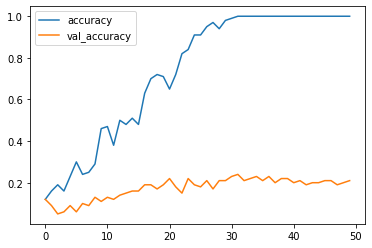

In [21]:
# Plot training and test curves
df = pd.DataFrame(history.history)
df.plot(y=['accuracy', 'val_accuracy'])
plt.show()

In [22]:
# Inspect the checkpoint directory
!ls -lh model_checkpoints_best

total 360K
-rw-rw-r-- 1 chanseok chanseok   77 11월 16 16:48 checkpoint
-rw-rw-r-- 1 chanseok chanseok 174K 11월 16 16:48 checkpoint.data-00000-of-00001
-rw-rw-r-- 1 chanseok chanseok 3.6K 11월 16 16:23 checkpoint.data-00000-of-00002
-rw-rw-r-- 1 chanseok chanseok 171K 11월 16 16:23 checkpoint.data-00001-of-00002
-rw-rw-r-- 1 chanseok chanseok 2.0K 11월 16 16:48 checkpoint.index


In [23]:
# Create a new model with the saved weights
new_model = get_new_model()
print('New model')
get_test_accuracy(new_model, X_test, y_test)
new_model.load_weights(checkpoint_best_path)
print('New model with loaded weight')
get_test_accuracy(new_model, X_test, y_test)

New model
Accuracy: 0.105
New model with loaded weight
Accuracy: 0.214


## Saving the entire model

### Create checkpoint that saves whole model, not just weights

In [24]:
# Create Tensorflow checkpoint object
checkpoint_path = 'model_checkpoints'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=False,
                             frequecy='epoch', verbose=1)

In [25]:
# Create and fit mode with checkpoint
model = get_new_model()
model.fit(X_train,
          y_train,
          epochs=3,
          callbacks=[checkpoint])

Epoch 1/3
308/313 [============================>.] - ETA: 0s - loss: 1.9763 - accuracy: 0.2832
Epoch 00001: saving model to model_checkpoints
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_checkpoints/assets
313/313 [==============================] - 1s 3ms/step - loss: 1.9731 - accuracy: 0.2844
Epoch 2/3
305/313 [============================>.] - ETA: 0s - loss: 1.6370 - accuracy: 0.4090
Epoch 00002: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_checkpoints/assets
313/313 [==============================] - 1s 3ms/step - loss: 1.6362 - accuracy: 0.4101
Epoch 3/3
306/313 [============================>.] - ETA: 0s - loss: 1.5090 - accuracy: 0.4564
Epoch 00003: saving model to model_checkpoints
INFO:tensorflow:Assets written to: model_c

### Inspect what the checkpoint has created

In [26]:
!ls -lh model_checkpoints/

total 488K
drwxr-xr-x 2 chanseok chanseok 4.0K 11월 16 16:26 assets
-rw-rw-r-- 1 chanseok chanseok   77 11월 16 16:48 checkpoint
-rw-rw-r-- 1 chanseok chanseok 174K 11월 16 16:48 checkpoint.data-00000-of-00001
-rw-rw-r-- 1 chanseok chanseok 3.6K 11월 16 16:22 checkpoint.data-00000-of-00002
-rw-rw-r-- 1 chanseok chanseok 171K 11월 16 16:22 checkpoint.data-00001-of-00002
-rw-rw-r-- 1 chanseok chanseok 2.0K 11월 16 16:48 checkpoint.index
-rw-rw-r-- 1 chanseok chanseok 120K 11월 16 16:48 saved_model.pb
drwxr-xr-x 2 chanseok chanseok 4.0K 11월 16 16:48 variables


In [27]:
!ls -lh model_checkpoints/variables/

total 364K
-rw-rw-r-- 1 chanseok chanseok 177K 11월 16 16:48 variables.data-00000-of-00001
-rw-rw-r-- 1 chanseok chanseok 6.3K 11월 16 16:26 variables.data-00000-of-00002
-rw-rw-r-- 1 chanseok chanseok 171K 11월 16 16:26 variables.data-00001-of-00002
-rw-rw-r-- 1 chanseok chanseok 2.2K 11월 16 16:48 variables.index


In [28]:
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.463


### Create new model from scratch

In [29]:
del model

In [30]:
from tensorflow.keras.models import load_model

model = load_model('./model_checkpoints/')
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.116


### Use the .h5 format to save model

In [31]:
model.save('my_model.h5')

In [32]:
!ls -lh my_model.h5

-rw-rw-r-- 1 chanseok chanseok 77K 11월 16 16:48 my_model.h5


In [33]:
del model

In [34]:
# Reload the model from scratch
model = load_model('my_model.h5')
get_test_accuracy(model, X_test, y_test)

Accuracy: 0.116


## Saving model architecture only

In this reading you will learn how to save a model's architecture, but not its weights.

### Accessing a model's configuration
A model's configuration refers to its architecture. TensorFlow has a convenient way to retrieve a model's architecture as a dictionary. We start by creating a simple fully connected feedforward neural network with 1 hidden layer.

In [35]:
model = Sequential([
    Dense(units=32, input_shape=(32, 32, 3), activation='relu', name='dense_1'),
    Dense(units=10, activation='softmax', name='dense_2')
])

In [36]:
config_dict = model.get_config()
config_dict

{'name': 'sequential_6',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 32, 32, 3),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_1_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'batch_input_shape': (None, 32, 32, 3),
    'dtype': 'float32',
    'units': 32,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_2',
    'trainable': True,
    'dtype': 'float32',
    'units': 10,
    'activation': 'softmax',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': N

### Creating a new model from the config
A new TensorFlow model can be created from this config dictionary. This model will have reinitialized weights, which are not the same as the original model.

In [37]:
model_same_config = tf.keras.Sequential.from_config(config_dict)

We can check explicitly that the config of both models is the same, but the weights are not:

In [38]:
print('Same config:', model.get_config() == model_same_config.get_config())
print('Same value for first weight matrix:', np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

Same config: True
Same value for first weight matrix: False


For models that are not `Sequential` models, use `tf.keras.Model.from_config` instead of `tf.keras.Sequential.from_config`.

### Other file formats: JSON and YAML

It is also possible to obtain a model's config in JSON or YAML formats. This follows the same pattern:

In [40]:
from pprint import pprint

# Convert the model to JSON
json_string = model.to_json()
pprint(json_string)

('{"class_name": "Sequential", "config": {"name": "sequential_6", "layers": '
 '[{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, '
 '3], "dtype": "float32", "sparse": false, "ragged": false, "name": '
 '"dense_1_input"}}, {"class_name": "Dense", "config": {"name": "dense_1", '
 '"trainable": true, "batch_input_shape": [null, 32, 32, 3], "dtype": '
 '"float32", "units": 32, "activation": "relu", "use_bias": true, '
 '"kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": '
 'null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, '
 '"kernel_regularizer": null, "bias_regularizer": null, '
 '"activity_regularizer": null, "kernel_constraint": null, "bias_constraint": '
 'null}}, {"class_name": "Dense", "config": {"name": "dense_2", "trainable": '
 'true, "dtype": "float32", "units": 10, "activation": "softmax", "use_bias": '
 'true, "kernel_initializer": {"class_name": "GlorotUniform", "config": '
 '{"seed": null}}, "bias_initialize

The JSON format can easily be written out and saved as a file:

In [41]:
import json

with open('config.json', 'w') as f:
    json.dump(json_string, f)
del json_string

In [42]:
!ls -lh config.json

-rw-rw-r-- 1 chanseok chanseok 1.3K 11월 16 16:51 config.json


In [44]:
# Read in JSON config file again
with open('config.json', 'r') as f:
    json_string = json.load(f)

In [45]:
# Reinitialize model
model_same_config = tf.keras.models.model_from_json(json_string)
print('Same config:', model.get_config() == model_same_config.get_config())
print('Same value for first weight matrix:', np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

Same config: True
Same value for first weight matrix: False


The YAML format is similar. The details of writing out YAML files, loading them and using them to create a new model are similar as for the JSON files

In [46]:
# Convert the model to YAML
yaml_string = model.to_yaml()
pprint(yaml_string)

('backend: tensorflow\n'
 'class_name: Sequential\n'
 'config:\n'
 '  layers:\n'
 '  - class_name: InputLayer\n'
 '    config:\n'
 '      batch_input_shape: !!python/tuple\n'
 '      - null\n'
 '      - 32\n'
 '      - 32\n'
 '      - 3\n'
 '      dtype: float32\n'
 '      name: dense_1_input\n'
 '      ragged: false\n'
 '      sparse: false\n'
 '  - class_name: Dense\n'
 '    config:\n'
 '      activation: relu\n'
 '      activity_regularizer: null\n'
 '      batch_input_shape: !!python/tuple\n'
 '      - null\n'
 '      - 32\n'
 '      - 32\n'
 '      - 3\n'
 '      bias_constraint: null\n'
 '      bias_initializer:\n'
 '        class_name: Zeros\n'
 '        config: {}\n'
 '      bias_regularizer: null\n'
 '      dtype: float32\n'
 '      kernel_constraint: null\n'
 '      kernel_initializer:\n'
 '        class_name: GlorotUniform\n'
 '        config:\n'
 '          seed: null\n'
 '      kernel_regularizer: null\n'
 '      name: dense_1\n'
 '      trainable: true\n'
 '      units: 3

In [47]:
import yaml

with open('config.yaml', 'w') as f:
    yaml.dump(yaml_string, f)
del yaml_string

In [48]:
!ls -lh config.yaml

-rw-rw-r-- 1 chanseok chanseok 1.5K 11월 16 16:54 config.yaml


In [50]:
with open('config.yaml', 'r') as f:
    yaml_string = yaml.load(f, Loader=yaml.FullLoader)

In [51]:
model_same_config = tf.keras.models.model_from_yaml(yaml_string)
print('Same config:', model.get_config() == model_same_config.get_config())
print('Same value for first weight matrix:', np.allclose(model.weights[0].numpy(), model_same_config.weights[0].numpy()))

Same config: True
Same value for first weight matrix: False


### Further reading and resources
* https://www.tensorflow.org/guide/keras/save_and_serialize#architecture-only_saving
* https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

## Loading pre-trained Keras models

### Import and build Keras ResNet50 moel

Today we'll be using the ResNet50 model designed by a team at Microsoft Research, available through Keras applications. Please see the description on the [Keras applications page](https://keras.io/applications/#resnet) for details. If you continue using it, please cite it properly! The paper it comes from is:

Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun. "Deep Residual Learning for Image Recognition", 2015.

This model takes a long time to download on the Coursera platform, so it is pre-downloaded in your workspace and saved in Keras HDF5 format. If you want to import it on your personal machine, use the following code:

```python
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')
```

In [52]:
from tensorflow.keras.applications import ResNet50
model = ResNet50(weights='imagenet')

102973440/102967424 [==============================] - 129s 1us/step


In [53]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Import and preprocess 3 sample images

In [54]:
from tensorflow.keras.preprocessing.image import load_img

lemon_img = load_img('./dataset/lemon.jpg', target_size=(224, 224))
viaduct_img = load_img('./dataset/viaduct.jpg', target_size=(224, 224))
water_tower_img = load_img('./dataset/water_tower.jpg', target_size=(224, 224))

### Use ResNet50 mdeol to classify images

In [56]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def get_top_5_predictions(img):
    # Add dummy batch size
    x = img_to_array(img)[tf.newaxis, ...]
    y = preprocess_input(x)
    preds = decode_predictions(model.predict(x), top=5)
    top_preds = pd.DataFrame(columns=['prediction', 'probability'], index=np.arange(5) + 1)
    
    for i in range(5):
        top_preds.loc[i + 1, 'prediction'] = preds[0][i][1]
        top_preds.loc[i + 1, 'probability'] = preds[0][i][2]
    return top_preds

### Image 1: lemon

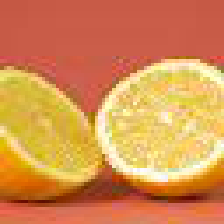

In [57]:
lemon_img

In [59]:
get_top_5_predictions(lemon_img)

,prediction,probability
1,golf_ball,0.206168
2,Petri_dish,0.195282
3,beaker,0.0671951
4,ping-pong_ball,0.0632187
5,spotlight,0.0342526


### Image 2: viaduct

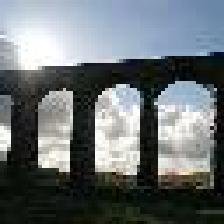

In [60]:
viaduct_img

In [61]:
get_top_5_predictions(viaduct_img)

,prediction,probability
1,vault,0.62282
2,prison,0.177996
3,window_screen,0.0584098
4,prayer_rug,0.0210803
5,shoji,0.0119673


### Image 3: water tower

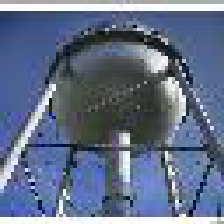

In [62]:
water_tower_img

In [63]:
get_top_5_predictions(water_tower_img)

,prediction,probability
1,collie,0.434751
2,tick,0.118883
3,gong,0.0996427
4,Arabian_camel,0.0555059
5,strainer,0.0332237


## Tensorflow Hub models

### Import and build Tensorflow Hub MobileNet v1 model

Today we'll be using Google's MobileNet v1 model, available on Tensorflow Hub. Please see the description on the [Tensorflow Hub page](https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4) for details on it's architecture, how it's trained, and the reference. If you continue using it, please cite it properly! The paper it comes from is:

Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, Hartwig Adam: "MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications", 2017.

In [64]:
import tensorflow_hub as hub

In [66]:
module_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
model = Sequential([hub.KerasLayer(module_url)])
model.build(input_shape=[None, 160, 160, 3])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              1343049   
Total params: 1,343,049
Trainable params: 0
Non-trainable params: 1,343,049
_________________________________________________________________


### Use MobileNet model to classify images

In [67]:
with open('./dataset/imagenet_categories.txt') as txt_file:
    categories = txt_file.read().splitlines()

In [68]:
def get_top_5_predictions(img):
    x = img_to_array(img)[tf.newaxis, ...] / 255.0
    preds = model.predict(x)
    top_preds = pd.DataFrame(columns=['prediction'], index=np.arange(5)+1)
    sorted_index = np.argsort(-preds[0])
    for i in range(5):
        ith_pred = categories[sorted_index[i]]
        top_preds.loc[i+1, 'prediction'] = ith_pred
    return top_preds

### Image 1: lemon

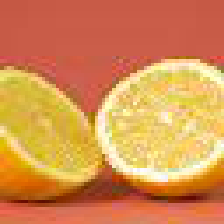

In [69]:
lemon_img

In [70]:
get_top_5_predictions(lemon_img)

,prediction
1,tray
2,shower cap
3,candle
4,toilet seat
5,shopping basket


### Image 2: Viaduct

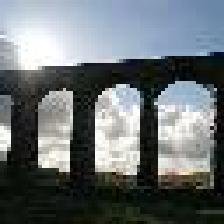

In [71]:
viaduct_img

In [72]:
get_top_5_predictions(viaduct_img)

,prediction
1,bell cote
2,viaduct
3,pedestal
4,monastery
5,triumphal arch


### Image 3: Water tower

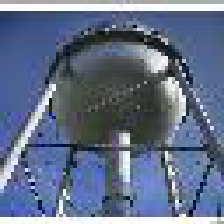

In [73]:
water_tower_img

In [76]:
get_top_5_predictions(water_tower_img)

,prediction
1,solar dish
2,prison
3,fountain
4,planetarium
5,jigsaw puzzle
